In [1]:
# @title 1. Setup, Unzip & Library Installation
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import AutoTokenizer

In [2]:
!pip install -q transformers sentencepiece

ZIP_FILE_PATH = "/content/lnu-deep-learn-2-text-classification-2025.zip"
EXTRACT_PATH = "/content/data/"
MODEL_NAME = "deepset/gbert-base"


if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)

if os.path.exists(ZIP_FILE_PATH):
    print(f"Unzipping {ZIP_FILE_PATH}...")
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Extraction complete.")
else:
    print(f"Warning: Zip file not found at {ZIP_FILE_PATH}. Please check path or upload manually.")

files = [f for f in os.listdir(EXTRACT_PATH) if f.endswith('.csv')]
print(f"Found files: {files}")

train_file = next((f for f in files if 'train' in f.lower()), None)
test_file = next((f for f in files if 'test' in f.lower()), None)

if train_file:
    df_train = pd.read_csv(os.path.join(EXTRACT_PATH, train_file))
    print(f"Train data loaded: {df_train.shape}")
else:
    print("Could not find train file automatically.")

if test_file:
    df_test = pd.read_csv(os.path.join(EXTRACT_PATH, test_file))
    print(f"Test data loaded: {df_test.shape}")
else:
    print("Could not find test file automatically.")

Unzipping /content/lnu-deep-learn-2-text-classification-2025.zip...
Extraction complete.
Found files: ['test.csv', 'sample_submission.csv', 'train.csv']
Train data loaded: (9245, 3)
Test data loaded: (1028, 2)


/tmp/ipython-input-3421350443.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=LABEL_COL, data=df_train, palette='viridis')


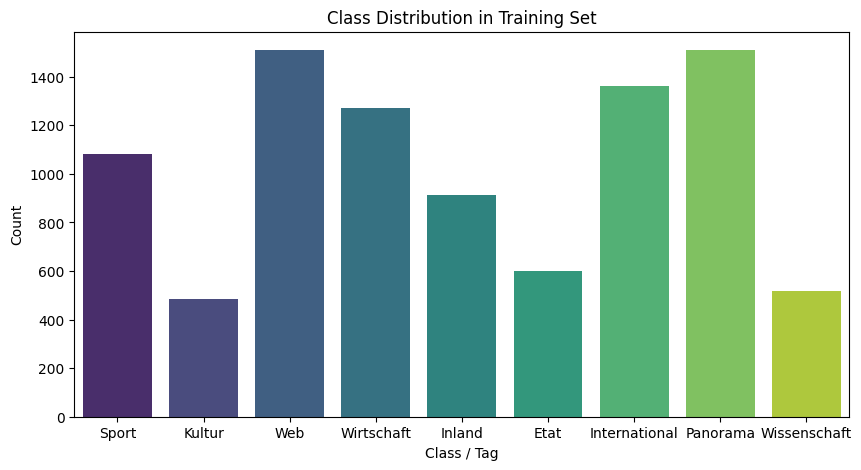


--- Class Balance ---
label
Panorama         16.333153
Web              16.322336
International    14.710654
Wirtschaft       13.737155
Sport            11.692807
Inland            9.875608
Etat              6.500811
Wissenschaft      5.581395
Kultur            5.246079
Name: proportion, dtype: float64


In [3]:
# @title 2. Data Analysis (EDA)
TEXT_COL = 'text'
LABEL_COL = 'label'


if train_file:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=LABEL_COL, data=df_train, palette='viridis')
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class / Tag')
    plt.ylabel('Count')
    plt.show()

    print("\n--- Class Balance ---")
    print(df_train[LABEL_COL].value_counts(normalize=True) * 100)

In [4]:
def get_text_metrics(df, text_col, tokenizer):
    texts = df[text_col].astype(str).tolist()

    token_counts = []
    unique_token_counts = []
    all_tokens = []

    print(f"Processing {len(texts)} texts with {tokenizer.name_or_path}...")

    for text in texts:
        tokens = tokenizer.tokenize(text)
        token_counts.append(len(tokens))
        unique_token_counts.append(len(set(tokens)))
        all_tokens.extend(tokens)

    return token_counts, unique_token_counts, all_tokens


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

metrics = {}
for name, df in [("Train", df_train), ("Test", df_test)]:
    if df is not None:
        print(f"\nAnalyzing {name} Data...")
        lens, uniques, tokens = get_text_metrics(df, TEXT_COL, tokenizer)
        metrics[name] = {
            "lengths": lens,
            "uniques": uniques,
            "tokens": tokens
        }

        print(f"--- {name} Statistics ---")
        print(f"Avg Length (tokens): {np.mean(lens):.2f}")
        print(f"Max Length (tokens): {np.max(lens)}")
        print(f"Avg Unique Tokens:   {np.mean(uniques):.2f}")
        print(f"Total Unique Vocab:  {len(set(tokens))}")

        common = Counter(tokens).most_common(10)
        print(f"Top 10 Tokens: {common}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (906 > 512). Running this sequence through the model will result in indexing errors



Analyzing Train Data...
Processing 9245 texts with deepset/gbert-base...
--- Train Statistics ---
Avg Length (tokens): 533.17
Max Length (tokens): 4512
Avg Unique Tokens:   296.32
Total Unique Vocab:  27607
Top 10 Tokens: [('.', 223139), (',', 192417), ('der', 98763), ('die', 91339), ('-', 63670), ('und', 63428), ('in', 57428), ('den', 36589), ('von', 32909), ('zu', 30270)]

Analyzing Test Data...
Processing 1028 texts with deepset/gbert-base...
--- Test Statistics ---
Avg Length (tokens): 540.89
Max Length (tokens): 6840
Avg Unique Tokens:   298.64
Total Unique Vocab:  23295
Top 10 Tokens: [('.', 25088), (',', 21973), ('der', 11235), ('die', 10013), ('und', 7210), ('-', 7100), ('in', 6543), ('den', 3976), ('von', 3587), ('zu', 3535)]


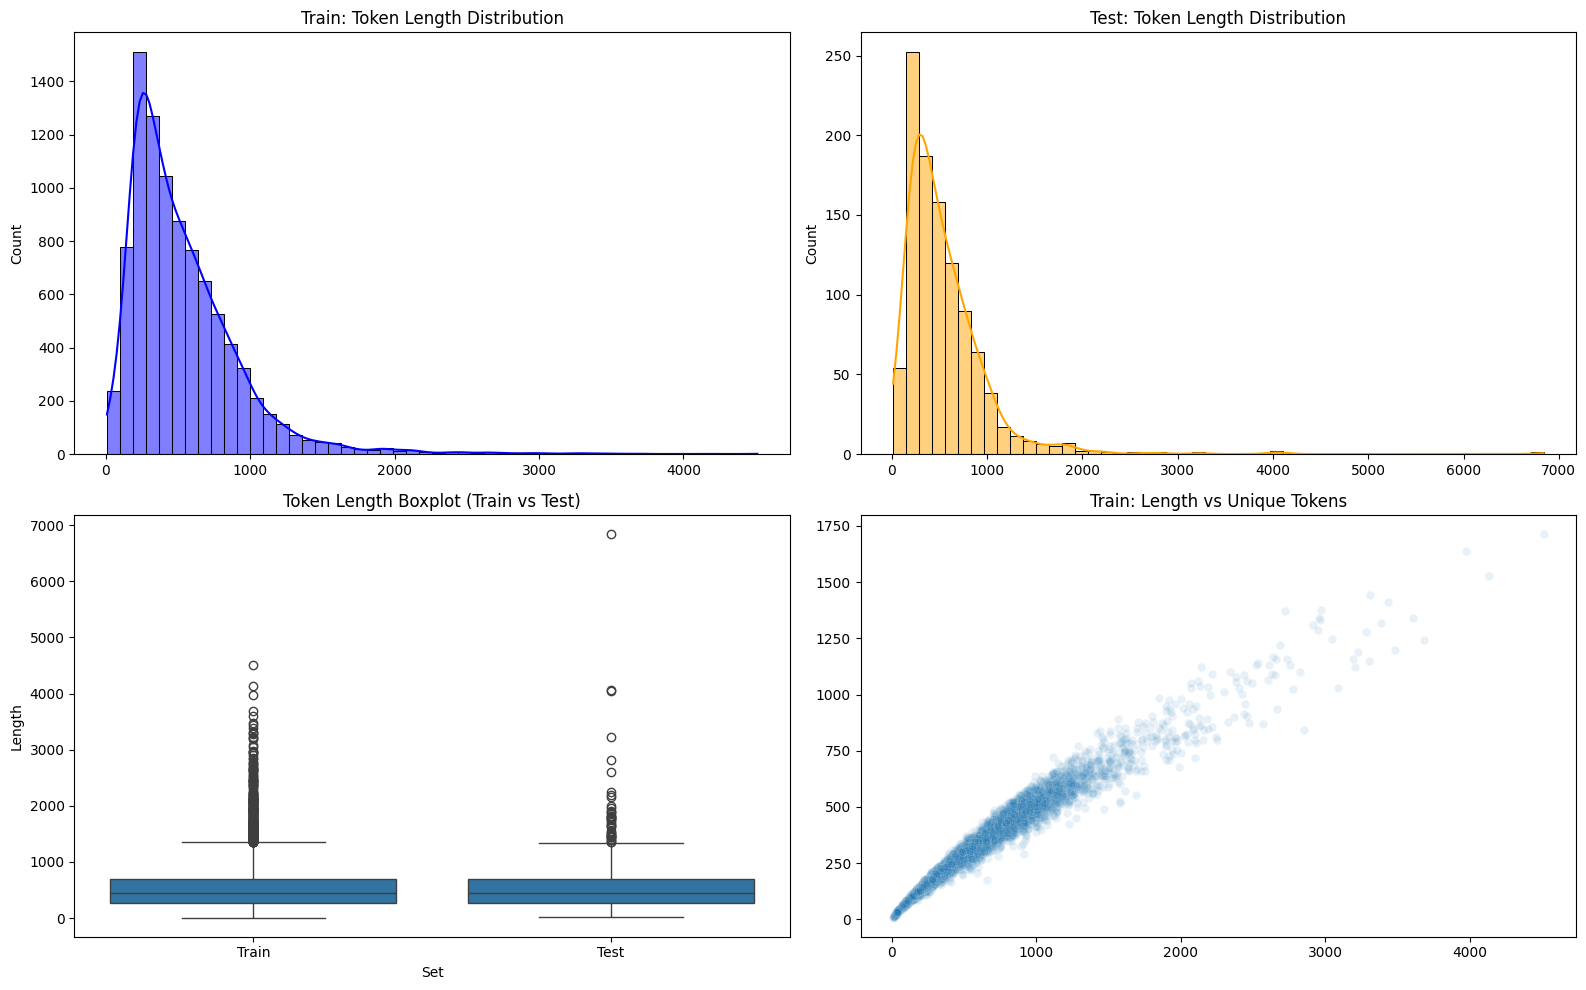

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))


sns.histplot(metrics["Train"]["lengths"], bins=50, ax=axes[0, 0], color='blue', kde=True)
axes[0, 0].set_title("Train: Token Length Distribution")


if "Test" in metrics:
    sns.histplot(metrics["Test"]["lengths"], bins=50, ax=axes[0, 1], color='orange', kde=True)
    axes[0, 1].set_title("Test: Token Length Distribution")


combined_lens = []
labels = []
combined_lens.extend(metrics["Train"]["lengths"])
labels.extend(["Train"] * len(metrics["Train"]["lengths"]))

if "Test" in metrics:
    combined_lens.extend(metrics["Test"]["lengths"])
    labels.extend(["Test"] * len(metrics["Test"]["lengths"]))

df_box = pd.DataFrame({"Length": combined_lens, "Set": labels})
sns.boxplot(x="Set", y="Length", data=df_box, ax=axes[1, 0])
axes[1, 0].set_title("Token Length Boxplot (Train vs Test)")


sns.scatterplot(x=metrics["Train"]["lengths"], y=metrics["Train"]["uniques"], alpha=0.1, ax=axes[1, 1])
axes[1, 1].set_title("Train: Length vs Unique Tokens")

plt.tight_layout()
plt.show()

In [6]:
# @title 3. Improved Preprocessing (Train Only)
import re
import html
import torch
import pickle
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm


def clean_german_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = " ".join(text.split())
    return text

print("Cleaning text (Normalization)...")
df_train['clean_text'] = df_train[TEXT_COL].apply(clean_german_text)


print("\nEncoding Labels...")
le = LabelEncoder()
df_train['label_ids'] = le.fit_transform(df_train[LABEL_COL])


with open(os.path.join(EXTRACT_PATH, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
print(f"Label map saved. Classes: {le.classes_}")


print(f"\nTokenizing with {MODEL_NAME}...")
texts = df_train['clean_text'].tolist()

encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)


save_path_pkl = os.path.join(EXTRACT_PATH, "train_processed.pkl")
save_path_pt = os.path.join(EXTRACT_PATH, "train_tensors.pt")

print(f"\nSaving to {save_path_pt}...")


df_train['input_ids'] = encoded_data['input_ids'].tolist()
df_train.to_pickle(save_path_pkl)


torch.save({
    'input_ids': encoded_data['input_ids'],
    'attention_mask': encoded_data['attention_mask'],
    'labels': torch.tensor(df_train['label_ids'].values, dtype=torch.long)
}, save_path_pt)

print("Train data normalized, encoded, and tokenized.")
print(f"Tensor Shape: {encoded_data['input_ids'].shape}")

Cleaning text (Normalization)...

Encoding Labels...
Label map saved. Classes: ['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']

Tokenizing with deepset/gbert-base...

Saving to /content/data/train_tensors.pt...
Train data normalized, encoded, and tokenized.
Tensor Shape: torch.Size([9245, 256])


In [7]:
!pip install -q mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 142.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.2/764.2 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.9 MB/s eta 0:00:00


In [8]:
# @title 4. MLflow Tuning & CV Training (With Learning Curve Plots)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from transformers import AutoModelForSequenceClassification, AutoConfig, get_linear_schedule_with_warmup, DataCollatorWithPadding, AutoTokenizer
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import random
import os
import mlflow
import pickle
from tqdm.notebook import tqdm

# --- SETUP & CONFIGURATION ---

EXTRACT_PATH = "/content/data/"
MLFLOW_PATH = "/content/mlflow_text_classification"
os.makedirs(MLFLOW_PATH, exist_ok=True)

mlflow.set_tracking_uri(f"file://{MLFLOW_PATH}")
print(f"MLflow Tracking URI set to: {MLFLOW_PATH}")

base_config = {
    "model_name": "deepset/gbert-base",
    "n_splits": 10,           # Main CV splits
    "epochs": 2,             # Main CV epochs
    "seed": 42,
    "max_grad_norm": 1.0,
    "weight_decay": 0.01,
    "grad_accum_steps": 1
}


param_grid = {
    "lr": [1e-5, 2e-5],
    "batch_size": [32]
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

set_seed(base_config['seed'])


MLflow Tracking URI set to: /content/mlflow_text_classification
Training on: Tesla T4


In [9]:
# --- DATASET & HELPERS ---

class GermanNewsDataset(Dataset):
    def __init__(self, tensors_path):
        data = torch.load(tensors_path)
        self.input_ids = data['input_ids']
        self.attention_mask = data['attention_mask']
        self.labels = data['labels']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


tensors_path = os.path.join(EXTRACT_PATH, "train_tensors.pt")
full_dataset = GermanNewsDataset(tensors_path)
all_labels = full_dataset.labels.numpy()
num_labels = len(np.unique(all_labels))


try:
    with open(os.path.join(EXTRACT_PATH, "label_encoder.pkl"), "rb") as f:
        le = pickle.load(f)
    class_names = list(le.classes_)
except:
    class_names = [str(i) for i in range(num_labels)]

print(f"Dataset Loaded. Samples: {len(full_dataset)} | Classes: {num_labels}")

Dataset Loaded. Samples: 9245 | Classes: 9


In [10]:
# --- PLOTTING & REPORTING FUNCTIONS ---

def plot_confusion_matrix(true, preds, labels):
    cm = confusion_matrix(true, preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    return fig

def plot_learning_curves(history, fold):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-o', label='Val Loss')
    ax1.set_title(f"Fold {fold}: Loss Curves")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Plot Metrics
    ax2.plot(epochs, history['val_f1'], 'g-s', label='Val F1')
    ax2.plot(epochs, history['val_acc'], 'k-s', label='Val Acc')
    ax2.set_title(f"Fold {fold}: Validation Metrics")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Score")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

def save_classification_report_artifact(true, preds, labels, fold, epoch):
    report_dict = classification_report(true, preds, target_names=labels, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    csv_name = f"class_report_fold_{fold}_epoch_{epoch}.csv"
    df_report.to_csv(csv_name)
    mlflow.log_artifact(csv_name)
    os.remove(csv_name)

def train_epoch(model, dataloader, optimizer, scheduler, scaler, device, grad_accum_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    # Added tqdm for progress bar (Verbosity)
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Training", leave=False)

    for step, batch in progress_bar:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss / grad_accum_steps

        scaler.scale(loss).backward()
        total_loss += loss.item() * grad_accum_steps

        # Gradient Accumulation Step
        if (step + 1) % grad_accum_steps == 0 or (step + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), base_config['max_grad_norm'])
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        # Update progress bar description every 10 steps to show current loss
        if step % 10 == 0:
            progress_bar.set_postfix({'loss': f"{loss.item() * grad_accum_steps:.4f}"})

    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    preds, true_labels = [], []
    val_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

            val_loss += outputs.loss.item()
            logits = outputs.logits.detach().cpu().numpy()
            preds.extend(np.argmax(logits, axis=1).flatten())
            true_labels.extend(b_labels.cpu().numpy().flatten())

    avg_loss = val_loss / len(dataloader)
    f1 = f1_score(true_labels, preds, average='weighted')
    acc = accuracy_score(true_labels, preds)
    return avg_loss, f1, acc, true_labels, preds

In [11]:
# --- 2. HYPERPARAMETER TUNING (Optimizing for Accuracy) ---
def find_best_hyperparameters(dataset, labels, grid, base_cfg):
    print("\nTUNING (Optimizing for Accuracy)...")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    tokenizer = AutoTokenizer.from_pretrained(base_cfg['model_name'])
    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    best_score = 0
    best_params = {}

    grid_list = list(ParameterGrid(grid))

    for i, params in enumerate(grid_list):
        print(f"\nTrial {i+1}/{len(grid_list)}: {params}")

        current_bs = params['batch_size']
        current_lr = params['lr']

        # Free memory
        torch.cuda.empty_cache()
        gc.collect()

        train_loader = DataLoader(
            train_ds,
            batch_size=current_bs,
            shuffle=True,
            collate_fn=collator,
            num_workers=2,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_ds,
            batch_size=current_bs,
            collate_fn=collator,
            num_workers=2,
            pin_memory=True
        )

        model = AutoModelForSequenceClassification.from_pretrained(
            base_cfg['model_name'], num_labels=num_labels
        ).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=current_lr, weight_decay=base_cfg['weight_decay'])
        scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * 2)
        scaler = torch.amp.GradScaler('cuda')

        mlflow.set_experiment("LNU_Tuning")
        with mlflow.start_run(run_name=f"Trial_{i+1}_lr{current_lr}_bs{current_bs}"):
            mlflow.log_params(params)
            mlflow.log_params(base_cfg)

            trial_best_acc = 0

            # Short training for tuning (2 epochs)
            for epoch in range(2):
                t_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, device, base_cfg['grad_accum_steps'])
                v_loss, v_f1, v_acc, _, _ = validate(model, val_loader, device)

                print(f"   Ep {epoch+1} | Acc: {v_acc:.4f} | F1: {v_f1:.4f} | Loss: {v_loss:.4f}")
                mlflow.log_metrics({"val_acc": v_acc, "val_f1": v_f1, "val_loss": v_loss}, step=epoch)

                if v_acc > trial_best_acc:
                    trial_best_acc = v_acc

            if trial_best_acc > best_score:
                best_score = trial_best_acc
                best_params = params

        del model, optimizer, scaler
        torch.cuda.empty_cache()

    print(f"\nBest Params Found: {best_params} (Best Acc: {best_score:.4f})")
    return best_params

In [12]:
import gc

def run_cross_validation(dataset, labels, cfg):
    skf = StratifiedKFold(n_splits=cfg['n_splits'], shuffle=True, random_state=cfg['seed'])
    tokenizer = AutoTokenizer.from_pretrained(cfg['model_name'])
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    fold_results_acc = [] # Track Accuracy
    mlflow.set_experiment("LNU_Final_CV_Training")

    print(f"\nStarting {cfg['n_splits']}-Fold Cross Validation with Params: {cfg}")

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n{'='*10} Fold {fold+1}/{cfg['n_splits']} {'='*10}")

        # Free memory
        torch.cuda.empty_cache()
        gc.collect()

        history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_acc': []}

        train_subsampler = SubsetRandomSampler(train_idx)
        val_subsampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(
            dataset,
            batch_size=cfg['batch_size'],
            sampler=train_subsampler,
            collate_fn=data_collator,
            num_workers=2,
            pin_memory=True
        )

        val_loader = DataLoader(
            dataset,
            batch_size=cfg['batch_size'],
            sampler=val_subsampler,
            collate_fn=data_collator,
            num_workers=2,
            pin_memory=True
        )

        model = AutoModelForSequenceClassification.from_pretrained(cfg['model_name'], num_labels=num_labels).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
        total_steps = len(train_loader) * cfg['epochs']
        scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)
        scaler = torch.amp.GradScaler('cuda')

        run_name = f"Fold_{fold+1}_Complete"
        with mlflow.start_run(run_name=run_name):
            mlflow.log_params(cfg)
            mlflow.log_param("fold", fold + 1)

            best_acc = 0

            for epoch in range(cfg['epochs']):
                print(f"Epoch {epoch+1}/{cfg['epochs']}")
                train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, device, cfg['grad_accum_steps'])


                val_loss, val_f1, val_acc, true_lbls, pred_lbls = validate(model, val_loader, device)


                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)
                history['val_f1'].append(val_f1)
                history['val_acc'].append(val_acc)

                metrics = {
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "val_f1": val_f1,
                    "val_acc": val_acc
                }
                mlflow.log_metrics(metrics, step=epoch)

                print(f"   -> Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")


                if val_acc > best_acc:
                    best_acc = val_acc


                    fig_cm = plot_confusion_matrix(true_lbls, pred_lbls, class_names)
                    mlflow.log_figure(fig_cm, f"confusion_matrix_fold_{fold+1}.png")
                    plt.close(fig_cm)

                    save_classification_report_artifact(true_lbls, pred_lbls, class_names, fold+1, epoch+1)


            fig_lc = plot_learning_curves(history, fold+1)
            mlflow.log_figure(fig_lc, f"learning_curves_fold_{fold+1}.png")
            plt.close(fig_lc)

            fold_results_acc.append(best_acc)
            print(f"Fold {fold+1} Finished. Best Accuracy: {best_acc:.4f}")

        del model, optimizer, scheduler, scaler
        torch.cuda.empty_cache()

    print(f"\nCV Average Accuracy: {np.mean(fold_results_acc):.4f} (+/- {np.std(fold_results_acc):.4f})")
    return fold_results_acc

In [13]:
"""
import torch
import gc

# 1. Delete standard heavy variables if they exist
sub_vars = ['model', 'optimizer', 'scheduler', 'scaler', 'encoded_data']
for v in sub_vars:
    if v in globals():
        print(f"Deleting {v}...")
        del globals()[v]

# 2. Force Python Garbage Collection (clears unreferenced variables)
gc.collect()

# 3. Clear PyTorch's internal cache
torch.cuda.empty_cache()

# 4. Check memory status
if torch.cuda.is_available():
    free_mem, total_mem = torch.cuda.mem_get_info()
    print(f"\n✅ Status Report:")
    print(f"Free Memory: {free_mem / 1024**3:.2f} GB")
    print(f"Total Memory: {total_mem / 1024**3:.2f} GB")

    if (free_mem / 1024**3) < 5.0:
        print("⚠️ Warning: GPU is still mostly full. You MUST restart the runtime.")
    else:
        print("🎉 Success! You have enough space to run the Base Model code now.")
else:
    print("❌ No GPU found.")
"""

'\nimport torch\nimport gc\n\n# 1. Delete standard heavy variables if they exist\nsub_vars = [\'model\', \'optimizer\', \'scheduler\', \'scaler\', \'encoded_data\']\nfor v in sub_vars:\n    if v in globals():\n        print(f"Deleting {v}...")\n        del globals()[v]\n\n# 2. Force Python Garbage Collection (clears unreferenced variables)\ngc.collect()\n\n# 3. Clear PyTorch\'s internal cache\ntorch.cuda.empty_cache()\n\n# 4. Check memory status\nif torch.cuda.is_available():\n    free_mem, total_mem = torch.cuda.mem_get_info()\n    print(f"\n✅ Status Report:")\n    print(f"Free Memory: {free_mem / 1024**3:.2f} GB")\n    print(f"Total Memory: {total_mem / 1024**3:.2f} GB")\n\n    if (free_mem / 1024**3) < 5.0:\n        print("⚠️ Warning: GPU is still mostly full. You MUST restart the runtime.")\n    else:\n        print("🎉 Success! You have enough space to run the Base Model code now.")\nelse:\n    print("❌ No GPU found.")\n'

In [14]:
best_params = find_best_hyperparameters(full_dataset, all_labels, param_grid, base_config)


TUNING (Optimizing for Accuracy)...

Trial 1/2: {'batch_size': 32, 'lr': 1e-05}


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/10 20:07:45 INFO mlflow.tracking.fluent: Experiment with name 'LNU_Tuning' does not exist. Creating a new experiment.


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   Ep 1 | Acc: 0.8399 | F1: 0.8379 | Loss: 0.5486


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   Ep 2 | Acc: 0.8664 | F1: 0.8660 | Loss: 0.4400

Trial 2/2: {'batch_size': 32, 'lr': 2e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   Ep 1 | Acc: 0.8664 | F1: 0.8667 | Loss: 0.4312


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   Ep 2 | Acc: 0.8859 | F1: 0.8857 | Loss: 0.3775

Best Params Found: {'batch_size': 32, 'lr': 2e-05} (Best Acc: 0.8859)


In [15]:
import json

final_config = base_config.copy()
final_config.update(best_params)

save_path = "/content/best_params.json"
print(f"\nSaving best parameters to {save_path}...")

with open(save_path, 'w') as f:
    json.dump(final_config, f, indent=4)

print("Parameters saved safely.")

cv_results = run_cross_validation(full_dataset, all_labels, final_config)


Saving best parameters to /content/best_params.json...
Parameters saved safely.


2025/12/10 20:13:38 INFO mlflow.tracking.fluent: Experiment with name 'LNU_Final_CV_Training' does not exist. Creating a new experiment.



Starting 10-Fold Cross Validation with Params: {'model_name': 'deepset/gbert-base', 'n_splits': 10, 'epochs': 2, 'seed': 42, 'max_grad_norm': 1.0, 'weight_decay': 0.01, 'grad_accum_steps': 1, 'batch_size': 32, 'lr': 2e-05}

========== Fold 1/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.7218 | Val Loss: 0.3357 | Acc: 0.8865 | F1: 0.8856
Epoch 2/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.2914 | Val Loss: 0.3114 | Acc: 0.8984 | F1: 0.8972
Fold 1 Finished. Best Accuracy: 0.8984

========== Fold 2/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.7350 | Val Loss: 0.3888 | Acc: 0.8811 | F1: 0.8806
Epoch 2/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.2881 | Val Loss: 0.3437 | Acc: 0.8984 | F1: 0.8979
Fold 2 Finished. Best Accuracy: 0.8984

========== Fold 3/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.7490 | Val Loss: 0.4042 | Acc: 0.8768 | F1: 0.8772
Epoch 2/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.2938 | Val Loss: 0.3740 | Acc: 0.8886 | F1: 0.8881
Fold 3 Finished. Best Accuracy: 0.8886

========== Fold 4/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.7213 | Val Loss: 0.3934 | Acc: 0.8746 | F1: 0.8739
Epoch 2/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.2860 | Val Loss: 0.3210 | Acc: 0.8876 | F1: 0.8872
Fold 4 Finished. Best Accuracy: 0.8876

========== Fold 5/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.7827 | Val Loss: 0.3871 | Acc: 0.8692 | F1: 0.8697
Epoch 2/2


Training:   0%|          | 0/260 [00:00<?, ?it/s]

   -> Train Loss: 0.2980 | Val Loss: 0.3579 | Acc: 0.8822 | F1: 0.8818
Fold 5 Finished. Best Accuracy: 0.8822

========== Fold 6/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.7161 | Val Loss: 0.3865 | Acc: 0.8788 | F1: 0.8781
Epoch 2/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.2760 | Val Loss: 0.3406 | Acc: 0.8810 | F1: 0.8800
Fold 6 Finished. Best Accuracy: 0.8810

========== Fold 7/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.7723 | Val Loss: 0.3597 | Acc: 0.8766 | F1: 0.8775
Epoch 2/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.2856 | Val Loss: 0.3258 | Acc: 0.8907 | F1: 0.8911
Fold 7 Finished. Best Accuracy: 0.8907

========== Fold 8/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.7195 | Val Loss: 0.3574 | Acc: 0.8918 | F1: 0.8932
Epoch 2/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.2869 | Val Loss: 0.3036 | Acc: 0.9037 | F1: 0.9036
Fold 8 Finished. Best Accuracy: 0.9037

========== Fold 9/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.7167 | Val Loss: 0.3774 | Acc: 0.8864 | F1: 0.8864
Epoch 2/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.2884 | Val Loss: 0.3351 | Acc: 0.8939 | F1: 0.8941
Fold 9 Finished. Best Accuracy: 0.8939

========== Fold 10/10 ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.7168 | Val Loss: 0.4008 | Acc: 0.8701 | F1: 0.8704
Epoch 2/2


Training:   0%|          | 0/261 [00:00<?, ?it/s]

   -> Train Loss: 0.2836 | Val Loss: 0.3719 | Acc: 0.8831 | F1: 0.8830
Fold 10 Finished. Best Accuracy: 0.8831

CV Average Accuracy: 0.8908 (+/- 0.0073)


In [18]:
# @title 7. Final Polish: Fine-Tune on 100% Data & Submit (Corrected)
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, RandomSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import os
import pickle
import numpy as np
import re
import html

EXTRACT_PATH = "/content/data/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fine_tune_config = {
    "model_name": "deepset/gbert-base",
    "epochs": 5,
    "lr": 2e-5,
    "batch_size": 32,
    "grad_accum_steps": 1,
    "seed": 42
}


def clean_german_text(text):
    if not isinstance(text, str): return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = " ".join(text.split())
    return text

with open(os.path.join(EXTRACT_PATH, "label_encoder.pkl"), "rb") as f:
    le = pickle.load(f)
num_labels = len(le.classes_)

tensors_path = os.path.join(EXTRACT_PATH, "train_tensors.pt")
train_data = torch.load(tensors_path)

class GermanNewsDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data['input_ids']
        self.attention_mask = data['attention_mask']
        self.labels = data['labels']
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {'input_ids': self.input_ids[idx], 'attention_mask': self.attention_mask[idx], 'labels': self.labels[idx]}

full_dataset = GermanNewsDataset(train_data)

tokenizer = AutoTokenizer.from_pretrained(fine_tune_config['model_name'])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_loader = DataLoader(
    full_dataset,
    batch_size=fine_tune_config['batch_size'],
    sampler=RandomSampler(full_dataset),
    collate_fn=data_collator,
    num_workers=2,
    pin_memory=True
)

files = [f for f in os.listdir(EXTRACT_PATH) if f.endswith('.csv')]
test_file = next((f for f in files if 'test' in f.lower()), None)
df_test = pd.read_csv(os.path.join(EXTRACT_PATH, test_file))


df_test['clean_text'] = df_test['text'].apply(clean_german_text) # Assumes column is 'text'

test_encodings = tokenizer.batch_encode_plus(
    df_test['clean_text'].tolist(),
    add_special_tokens=True,
    max_length=256,          # Fixed: Match training length for best accuracy
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

class TestDataset(Dataset):
    def __init__(self, encodings):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
    def __len__(self): return len(self.input_ids)
    def __getitem__(self, idx):
        return {'input_ids': self.input_ids[idx], 'attention_mask': self.attention_mask[idx]}

test_dataset = TestDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=data_collator)



In [19]:
# --- INITIALIZE & TRAIN MODEL ---
print(f"\nInitializing Fresh {fine_tune_config['model_name']} & Training...")

model = AutoModelForSequenceClassification.from_pretrained(fine_tune_config['model_name'], num_labels=num_labels)
model.gradient_checkpointing_enable() # Memory Saver
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=fine_tune_config['lr'], weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * fine_tune_config['epochs'])
scaler = torch.amp.GradScaler('cuda')

model.train()
epoch_losses = []

for epoch in range(fine_tune_config['epochs']):
    total_loss = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}", leave=False)

    for step, batch in pbar:
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(b_input, attention_mask=b_mask, labels=b_labels)
            loss = outputs.loss / fine_tune_config['grad_accum_steps']

        scaler.scale(loss).backward()
        total_loss += loss.item() * fine_tune_config['grad_accum_steps']

        # Optimizer Step (Accumulated)
        if (step + 1) % fine_tune_config['grad_accum_steps'] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

            if step % 50 == 0:
                pbar.set_postfix({'loss': f"{total_loss/(step+1):.4f}"})

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Done. Avg Loss: {avg_loss:.4f}")




Initializing Fresh deepset/gbert-base & Training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/289 [00:00<?, ?it/s]

Epoch 1 Done. Avg Loss: 0.6909


Epoch 2:   0%|          | 0/289 [00:00<?, ?it/s]

Epoch 2 Done. Avg Loss: 0.2806


Epoch 3:   0%|          | 0/289 [00:00<?, ?it/s]

Epoch 3 Done. Avg Loss: 0.1571


Epoch 4:   0%|          | 0/289 [00:00<?, ?it/s]

Epoch 4 Done. Avg Loss: 0.0939


Epoch 5:   0%|          | 0/289 [00:00<?, ?it/s]

Epoch 5 Done. Avg Loss: 0.0598


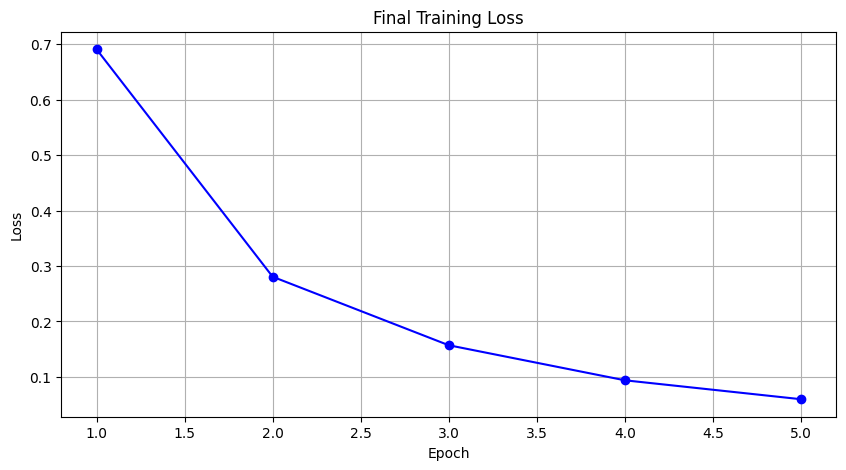

In [20]:
# --- PLOT TRAINING RESULTS ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, fine_tune_config['epochs'] + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.title('Final Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [21]:
# --- PREDICT ON TEST SET ---
print("\nPredicting on Test Set...")
model.eval()
all_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Inference"):
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(b_input, attention_mask=b_mask)

        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)


Predicting on Test Set...


Inference:   0%|          | 0/65 [00:00<?, ?it/s]

In [22]:
# --- SAVE SUBMISSION ---
final_labels = le.inverse_transform(all_preds)

id_col = df_test['id'] if 'id' in df_test.columns else range(len(final_labels))

submission = pd.DataFrame({
    'id': id_col,
    'label': final_labels
})

save_path = "/content/submission_final.csv"
submission.to_csv(save_path, index=False)

print(f"\nDONE! Download your file here: {save_path}")
print(submission.head())


DONE! Download your file here: /content/submission_final.csv
                                 id          label
0  4ffe04ebd43e4441ab2ac26c1ce57990     Wirtschaft
1  52637894c098414e9bdd1caab65c4349          Sport
2  93f5aa94b3aa49d6bec7677687048b0e            Web
3  8a6e232dd63a4c62a644cfe0a2f787cd          Sport
4  aa2f7d04b1364ab18363e30e7305ae01  International



Running Final Evaluation on Training Data...
   (This might take a minute...)


Evaluating Train Data:   0%|          | 0/289 [00:00<?, ?it/s]


FINAL TRAINING CLASSIFICATION REPORT
               precision    recall  f1-score   support

         Etat       0.99      0.99      0.99       601
       Inland       0.98      0.97      0.98       913
International       0.99      0.99      0.99      1360
       Kultur       0.99      0.98      0.99       485
     Panorama       0.98      0.99      0.98      1510
        Sport       1.00      1.00      1.00      1081
          Web       1.00      1.00      1.00      1509
   Wirtschaft       0.99      0.99      0.99      1270
 Wissenschaft       0.99      0.99      0.99       516

     accuracy                           0.99      9245
    macro avg       0.99      0.99      0.99      9245
 weighted avg       0.99      0.99      0.99      9245



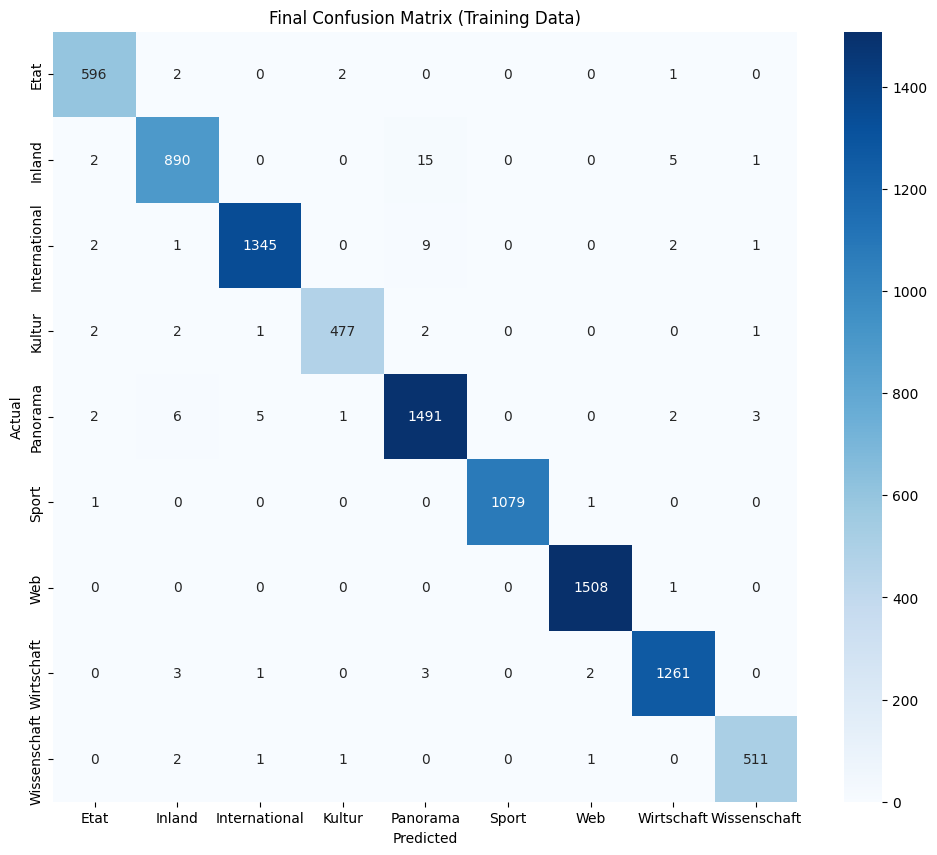


Sanity Check Complete.


In [23]:
# @title 8. Final Sanity Check: Evaluate on Training Data

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("\nRunning Final Evaluation on Training Data...")

model.eval()
train_preds = []
train_true = []

print("   (This might take a minute...)")
with torch.no_grad():
    for batch in tqdm(train_loader, desc="Evaluating Train Data"):
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(b_input, attention_mask=b_mask)

        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = b_labels.cpu().numpy()

        train_preds.extend(preds)
        train_true.extend(labels)

train_preds_named = le.inverse_transform(train_preds)
train_true_named = le.inverse_transform(train_true)
class_names = list(le.classes_)

print("\n" + "="*40)
print("FINAL TRAINING CLASSIFICATION REPORT")
print("="*40)
print(classification_report(train_true_named, train_preds_named, target_names=class_names))


cm = confusion_matrix(train_true_named, train_preds_named, labels=class_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix (Training Data)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nSanity Check Complete.")

In [26]:
# @title Download MLflow Logs
import shutil
import os
from google.colab import files

FOLDER_TO_ZIP = "/content/mlflow_text_classification"
OUTPUT_FILENAME = "mlflow_backup"

if os.path.exists(FOLDER_TO_ZIP):
    print(f"Zipping '{FOLDER_TO_ZIP}'...")

    zip_path = shutil.make_archive(f"/content/{OUTPUT_FILENAME}", 'zip', FOLDER_TO_ZIP)

    print(f"Created: {zip_path}")
    print(f"Starting download... (Check your browser downloads)")

    files.download(zip_path)
else:
    print(f"Error: The folder '{FOLDER_TO_ZIP}' does not exist.")
    print(" Did you name it something else? Check the file browser on the left.")

Zipping '/content/mlflow_text_classification'...
Created: /content/mlflow_backup.zip
Starting download... (Check your browser downloads)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>